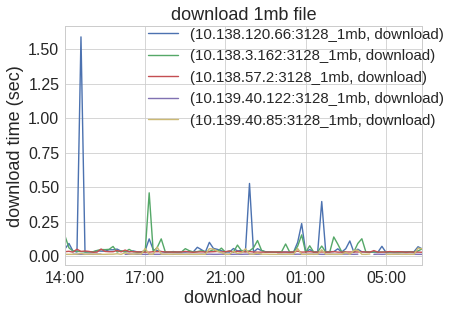

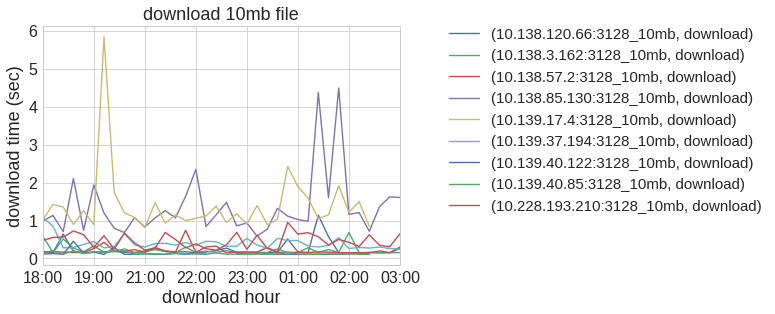

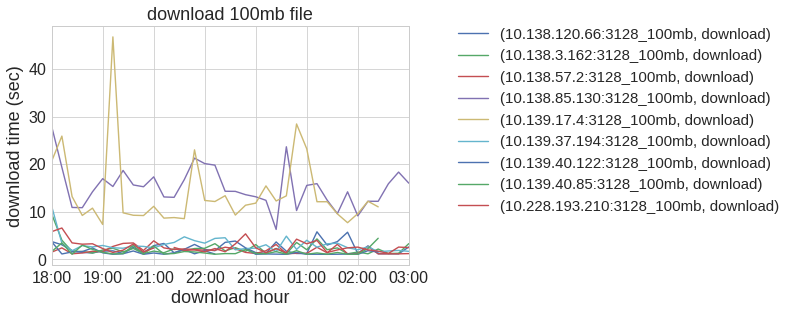

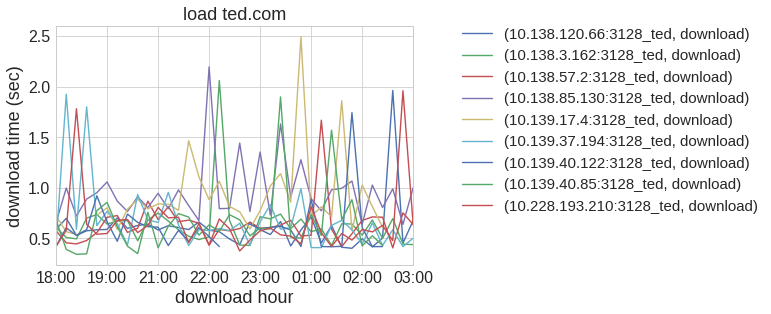

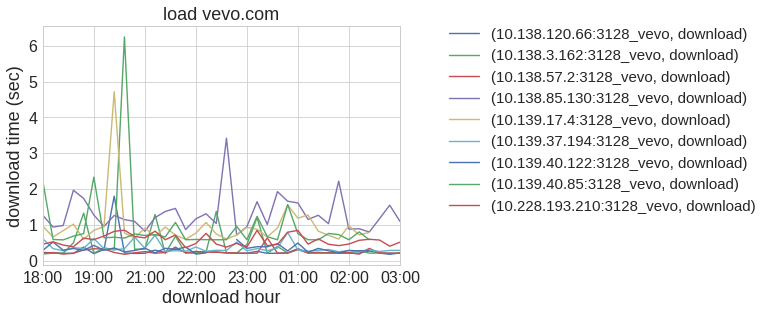

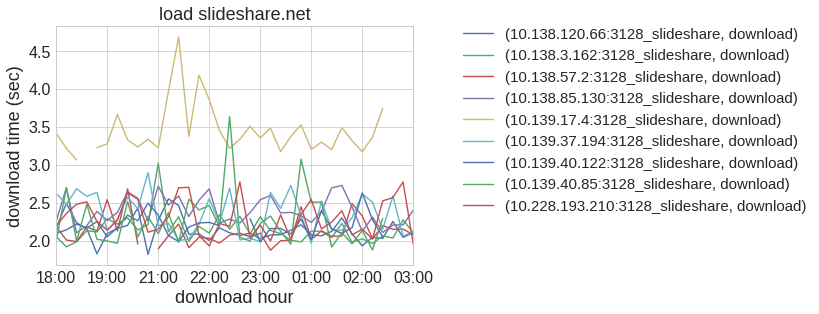

In [13]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

EXP_1NAME = "inputs/lluc/8clients/74/1mb"
EXP_10NAME = "inputs/lluc/8clients/74/10mb"
EXP_100NAME = "inputs/lluc/8clients/74/100mb"
EXP_SLIDENAME = "inputs/lluc/8clients/74/slideshare"
EXP_VEVNAME = "inputs/lluc/8clients/74/vevo"
EXP_TEDNAME = "inputs/lluc/8clients/74/ted"

MAX_ROUNDS = 70
MAX_YVAL = 5

RESULTS_DIR = os.path.join( os.getcwd(),'results')
INPUT_DIR = os.path.join( os.getcwd(), EXP_1NAME)

headers = ['date', 'download', 'code'] 
dtypes = [pd.datetime, float, float]

##SET SEABORN STYLE
sns.set_style("whitegrid")
sns.set_context("paper")

##SET MATPLOTLIB STYLE
TICKS_FONTSIZE = 16
LABEL_FONTSIZE=18
LEGEND_FONTSIZE=15
linestyles = (':','-','.','--')

mpl.rcParams['xtick.labelsize'] = TICKS_FONTSIZE 
mpl.rcParams['ytick.labelsize'] = TICKS_FONTSIZE
mpl.rcParams['legend.fontsize'] = TICKS_FONTSIZE
mpl.rcParams['axes.labelsize'] = LABEL_FONTSIZE
mpl.rcParams['axes.titlesize'] = LABEL_FONTSIZE
mpl.rcParams['font.size'] = LABEL_FONTSIZE
plt.rc('legend',**{'fontsize':LEGEND_FONTSIZE})


#Read input files from the directory and returns DataTable object in a combined list
def read_inputs(exp_name, columns):
    #Get list of nodes(files) with results
    INPUT_DIR = os.path.join( os.getcwd(), exp_name)
    nodes = [f for f in os.listdir(INPUT_DIR) if os.path.isfile(os.path.join(INPUT_DIR, f))]
    #Load results from each node
    nodes_results = {}
    for node in nodes:
        f = os.path.join(INPUT_DIR,node)
        try:
            nodes_results[node] = pd.read_csv(f,  usecols=columns, parse_dates=['date'], index_col=0).query('status == 200')
            nodes_results[node] = nodes_results[node].drop(['status'],1)
            nodes_results[node] = nodes_results[node].replace('None',np.nan)
        except Exception:
            print(node, 'EXception')
    return nodes_results

def plot_var_per_round(results, var):
    """Plot the median acrros nodes of a variable"""
    median = getMedianDF(results,var)
    #Create new figure
    fig = plt.figure()
    #Print the plot
    median.plot()
    #Modify parameters
    plt.ylabel(var)
    #plt.xlabel('Date')
    plt.xlim(0,MAX_ROUNDS)
    plt.show()

# Plot results to the separately
def plot_separately(results,y_label, legends):
    df = pd.concat(results,axis=1)
    df.index = df.index.to_series().dt.strftime('%H:00')
    ax = df.plot(title=y_label)
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    #print(df.mean())
    ax.set_xlabel('download hour')
    ax.set_ylabel('download time (sec)')
    #plt.ylim(0,0.25)
    plt.show()
    



if __name__ == '__main__':
    nodes_results1 = read_inputs(EXP_1NAME,["date", "download", "status"])
    nodes_results2 = read_inputs(EXP_10NAME,["date", "download", "status"])
    nodes_results3 = read_inputs(EXP_100NAME,["date", "download", "status"])
    nodes_results4 = read_inputs(EXP_TEDNAME,["date", "download", "status"])
    nodes_results5 = read_inputs(EXP_VEVNAME, ["date", "download", "status"])
    nodes_results6 = read_inputs(EXP_SLIDENAME, ["date", "download", "status"])
    plot_separately(nodes_results1, 'download 1mb file', list(nodes_results1))
    plot_separately(nodes_results2, 'download 10mb file', list(nodes_results2))    
    plot_separately(nodes_results3, 'download 100mb file', list(nodes_results3))
    plot_separately(nodes_results4, 'load ted.com', list(nodes_results3))
    plot_separately(nodes_results5, 'load vevo.com', list(nodes_results3))
    plot_separately(nodes_results6, 'load slideshare.net', list(nodes_results3))

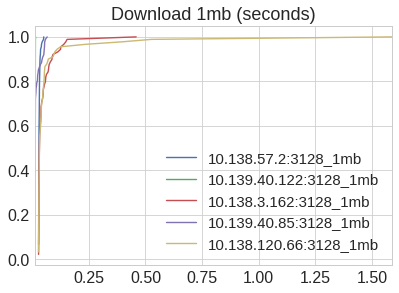

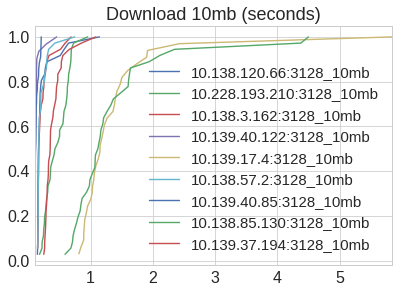

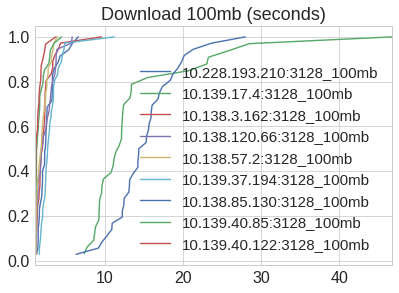

In [14]:
def plot_ecdf(results, var, title):
    """Plot the ECDF of the median accross the nodes of a variable"""
    lbl = []
    for v in var:
        series = pd.Series(results[v].download)
        ecdf = getECDF(results[v])
        ecdf.plot(title=title)
        lbl.append(v)
    plt.legend(lbl, loc = 'lower right')
    
    #plt.xlim(0,1)
    plt.show()
    
######### Assistant functions###############

def getECDF(df):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df.download.value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf


if __name__ == '__main__':
    nodes_results1 = read_inputs(EXP_1NAME,["date", "download", "status"])
    nodes_results2 = read_inputs(EXP_10NAME,["date", "download", "status"])
    nodes_results3 = read_inputs(EXP_100NAME,["date", "download", "status"])
    
    
    plot_ecdf(nodes_results1, list(nodes_results1), 'Download 1mb (seconds)')
    plot_ecdf(nodes_results2, list(nodes_results2), 'Download 10mb (seconds)')
    plot_ecdf(nodes_results3, list(nodes_results3), 'Download 100mb (seconds)')

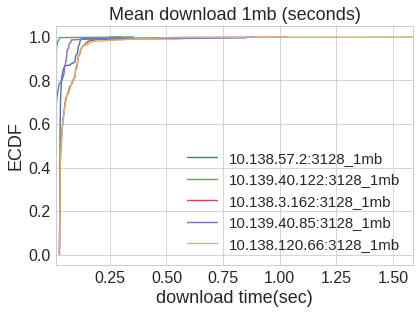

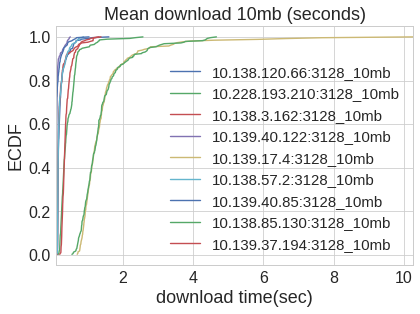

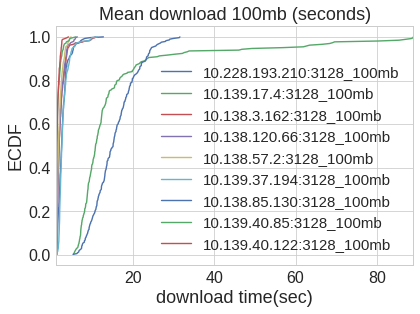

In [16]:
INPUT_DIR = "inputs/lluc/8clients/"

def plot_mean_ecdf(test,inputs, title):
    results = {}
    for client in inputs:
        nodes = read_inputs(INPUT_DIR+client+'/'+test, ["date", "download", "status"])
        keys = list(nodes)
        for key in keys:
            if key in results.keys():
                results[key] = pd.concat([results[key], pd.DataFrame(nodes[key].download)])
            else:
                results[key] = pd.DataFrame(nodes[key].download)
    lbl = []
    for key in list(results):
        results[key].index = pd.to_datetime(results[key].index)
        ecdf = getECDF(results[key])
        ax = ecdf.plot(title=title)
        ax.set_ylabel('ECDF')
        ax.set_xlabel('download time(sec)')
        lbl.append(key)
    
    plt.legend(lbl, loc = 'lower right')
    #lt.xlim(0,3)
    plt.show()


def plot_mean(test,inputs, title):
    results = {}
    for client in inputs:
        nodes = read_inputs(INPUT_DIR+'/'+client+'/'+test, ["date", "download", "status"])
        keys = list(nodes)
        for key in keys:
            if key in results.keys():
                results[key] = pd.concat([results[key], pd.DataFrame(nodes[key].download)])
            else:
                results[key] = pd.DataFrame(nodes[key].download)
    
    df = pd.concat(results,axis=1)
    df.plot(subplots=True)
    plt.show()
    

    
if __name__ == '__main__':
    inputs = ['74','77','78','115','116','118','180','181']
    plot_mean_ecdf('1mb', inputs, 'Mean download 1mb (seconds)')
    plot_mean_ecdf('10mb', inputs, 'Mean download 10mb (seconds)')
    plot_mean_ecdf('100mb', inputs, 'Mean download 100mb (seconds)')
    
    #plot_mean('1mb', inputs, 'Mean download 1mb (seconds)')
    #plot_mean('10mb', inputs, 'Mean download 10mb (seconds)')
    #plot_mean('100mb', inputs, 'Mean download 10mb (seconds)')

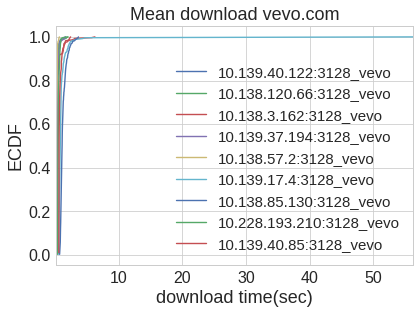

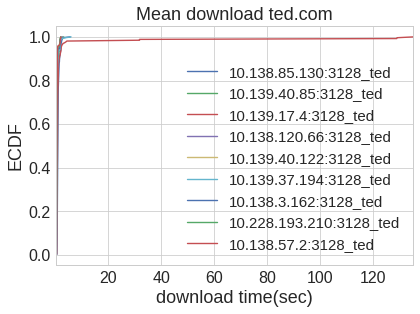

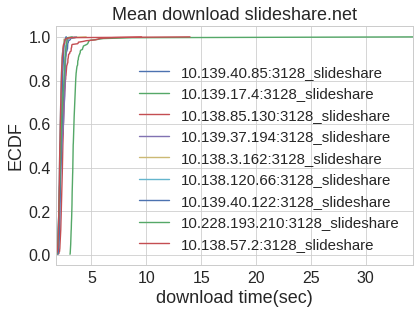

In [17]:
#def plot_download_websit():
    
if __name__ == '__main__':
    inputs = ['74','77','78','115','116','118','180','181']
    plot_mean_ecdf('vevo', inputs, 'Mean download vevo.com')
    plot_mean_ecdf('ted', inputs, 'Mean download ted.com')
    plot_mean_ecdf('slideshare', inputs, 'Mean download slideshare.net')